# Dataset

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import sys
%matplotlib inline


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Dress  Bag  Coat  Coat


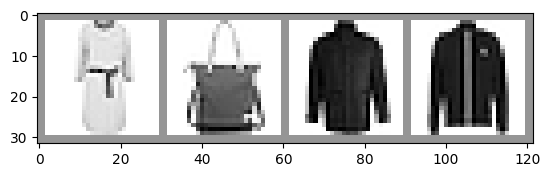

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

# Model

The model we’ll use in this example is a variant of LeNet-5 - it should
be familiar if you’ve watched the previous videos in this series.




In [16]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

model = GarmentClassifier()

## Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration
purposes, we’ll create batches of dummy output and label values, run
them through the loss function, and examine the result.




In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.5198, 0.7910, 0.7084, 0.4269, 0.2749, 0.3064, 0.9589, 0.9470, 0.2710,
         0.2559],
        [0.2141, 0.2863, 0.6860, 0.6212, 0.3132, 0.0480, 0.1436, 0.6864, 0.5413,
         0.6771],
        [0.2362, 0.0017, 0.3304, 0.2004, 0.3659, 0.0420, 0.2389, 0.2084, 0.9578,
         0.1744],
        [0.7195, 0.5329, 0.3082, 0.0897, 0.5054, 0.3988, 0.5106, 0.9650, 0.6981,
         0.3625]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2715394496917725


# Optimizer

In [18]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Metrics

# Training pipeline

In [19]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
    
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print(f'Loss after sample {i + 1}: {last_loss}')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    
    return last_loss

In [20]:
from training.validation_metrics import calculate_metric
from sklearn.metrics import f1_score

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'logs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 7

best_vloss = sys.float_info.max

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # Set the model to evaluation mode, disabling dropout and using population 
    # statistics for batch normalization.
    model.eval()
    running_vloss = 0.0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print("#############################################################")
    print("Epoch results:")
    print(f'Loss train {avg_loss} valid loss: {avg_vloss}')
    validation_f1_score = calculate_metric(model, validation_loader, metric=f1_score)
    train_f1_score = None
    print(f'F1 score train {train_f1_score} valid f1 score {validation_f1_score}')
    print("#############################################################\n\n")
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    
    writer.add_scalars('Macro_averaged_f1_score',
                    { 'Validation' : validation_f1_score},
                    epoch_number + 1)
    
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
Loss after sample 1000: 1.8948269291818143
Loss after sample 2000: 0.8438374758260324
Loss after sample 3000: 0.6965665432717651
Loss after sample 4000: 0.6397723929099739
Loss after sample 5000: 0.5723190686730668
Loss after sample 6000: 0.5367084819879383
Loss after sample 7000: 0.53121544493502
Loss after sample 8000: 0.48371551104914395
Loss after sample 9000: 0.4977609337142203
Loss after sample 10000: 0.45415499647147956
Loss after sample 11000: 0.4681046385422378
Loss after sample 12000: 0.4350579361511627
Loss after sample 13000: 0.4101076378423022
Loss after sample 14000: 0.4074860269461642
Loss after sample 15000: 0.3666826373486547
#############################################################
Epoch results:
Loss train 0.3666826373486547 valid loss: 0.4225538671016693
F1 score train None valid f1 score 0.8436696056404278
#############################################################


EPOCH 2:
Loss after sample 1000: 0.3964561949640047
Loss after sample 2000: 0.400602

In [21]:
import torch
torch.cuda.is_available()

True

In [22]:
torch.cuda.device_count()

1

In [23]:
 torch.cuda.current_device()

0

In [24]:
torch.cuda.device(0)
#tensorboard --logdir=logs